## Imports & Cache Setup

In [19]:
import fastf1
import fastf1.plotting
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

#enable FastF1 cache
fastf1.Cache.enable_cache(r"C:\UNI\Code\F1_Race_Predictor\cache")

## Load Sessions

In [20]:

#load qualifying & race sessions
season = 2023
gp = 'Bahrain'

qualifying = fastf1.get_session(season, gp, 'Q')
qualifying.load()

race = fastf1.get_session(season, gp, 'R')
race.load()

print(f"Loaded {gp} {season} Qualifying & Race")

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '55', '14', '63', '44', '18', '31', '27', '4', '77', '24', '22', '23', '2', '20', '81', '21', '10']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached d

Loaded Bahrain 2023 Qualifying & Race


## Williams Results

In [21]:
#Extracting Williams results
q_results = qualifing.results
r_results = race.results

williams_q = q_results[q_results['TeamName'] == 'Williams']
williams_r = r_results[r_results['TeamName'] == 'Williams']

print("Williams Qualifying Results:")
display(williams_q[['DriverNumber', 'Abbreviation', 'Position', 'Q1', 'Q2', 'Q3']])

print("Williams Race Results:")
display(williams_r[['DriverNumber', 'Abbreviation', 'Position', 'Status']])

Williams Qualifying Results:


,DriverNumber,Abbreviation,Position,Q1,Q2,Q3
23,23,ALB,15.0,0 days 00:01:31.461000,NaT,NaT
2,2,SAR,16.0,0 days 00:01:31.652000,NaT,NaT


Williams Race Results:


,DriverNumber,Abbreviation,Position,Status
23,23,ALB,10.0,Finished
2,2,SAR,12.0,Lapped


## Simple Lap Time Exploration

In [11]:
#Explore Williams lap times
laps = race.laps.pick_teams('Williams')

# Average lap times per Williams driver
avg_lap_times = laps.groupby('Driver')['LapTime'].mean().dt.total_seconds()

# Format into M:SS.mmm
def format_laptime(seconds):
    minutes = int(seconds // 60)
    secs = seconds % 60
    return f"{minutes}:{secs:06.3f}"

print("Average Lap Times (Williams Drivers):")
for driver, t in avg_lap_times.items():
    print(f"{driver}: {format_laptime(t)}")


Average Lap Times (Williams Drivers):
ALB: 1:40.465
SAR: 1:40.676


## Speed Trace Plot

### First Attept

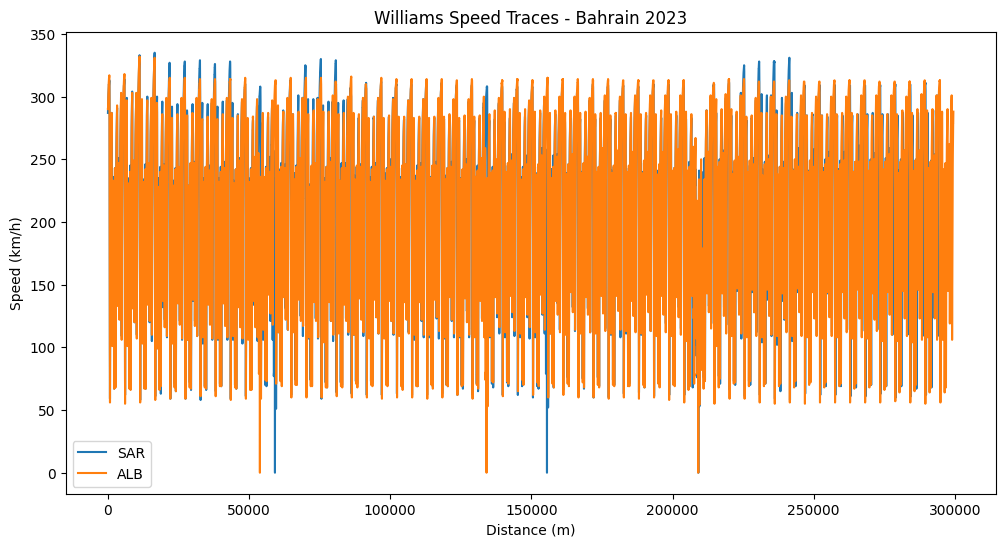

In [12]:
#Plot speed traces for Williams drivers
drivers = laps['Driver'].unique()

plt.figure(figsize=(12, 6))
for drv in drivers:
    drv_laps = laps.pick_drivers(drv).pick_quicklaps().get_car_data().add_distance()
    plt.plot(drv_laps['Distance'], drv_laps['Speed'], label=drv)

plt.title(f'Williams Speed Traces - {gp} {season}')
plt.xlabel('Distance (m)')
plt.ylabel('Speed (km/h)')
plt.legend()
plt.show()

-Each line is speed (km/h) across distance travelled (m) for every lap of both Williams drivers in Bahrain 2023.

-Since F1 cars do ~300 km in a race with ~57 laps in Bahrain, we're plotting every lap for every driver → they overlap, making a dense “barcode” of speed traces (caused by immediate change of speed: overtaking → more speed, after overtaking → reduce speed (defensive position)).

-That’s why ALB (orange) completely covers SAR (blue).

### Second Attept (refined & improved)

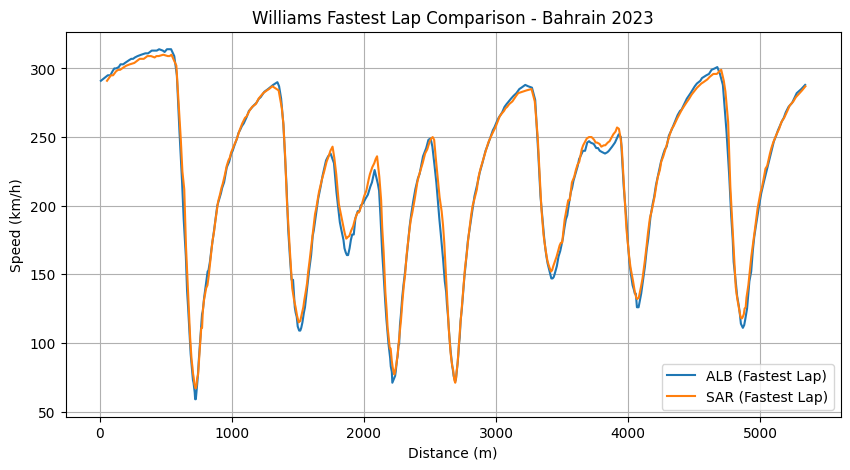

In [13]:
# One plot with both drivers' fastest laps
plt.figure(figsize=(10, 5))

for drv in ['ALB', 'SAR']:
    fastest = laps.pick_drivers(drv).pick_fastest()
    tel = fastest.get_car_data().add_distance()
    plt.plot(tel['Distance'], tel['Speed'], label=f"{drv} (Fastest Lap)")

plt.xlabel("Distance (m)")
plt.ylabel("Speed (km/h)")
plt.title("Williams Fastest Lap Comparison - Bahrain 2023")
plt.legend()
plt.grid(True)
plt.show()

### Interpretation of Williams Fastest Lap Comparison – Bahrain 2023  

This graph shows the **speed traces of both Williams drivers (Albon and Sargeant)** during their fastest laps at the 2023 Bahrain Grand Prix. Both drivers’ traces closely overlap across the entire lap, indicating that the **car’s performance ceiling is consistent** between the two.  

**Key takeaways:**  
- **Similarity in traces**: The near-identical speed curves confirm that the Williams FW45 had balanced performance and both drivers were extracting comparable pace.  
- **Minor differences**: Small variations in braking points and acceleration out of corners reflect **driver style differences** rather than car limitations.  
- **Driver parity**: On their fastest laps, Sargeant was close to Albon, showing that **qualifying pace was not heavily driver-dependent** at this race.  
- **Insight for prediction**: Since both drivers achieve similar peak performance in qualifying, final race outcomes for Williams are likely to be influenced more by **external factors** (strategy, tyre wear, incidents, track position) rather than pure lap-time pace differences between teammates.  


## Observations

- How did Williams qualify compared to final results?

    The fastest lap speed traces of Albon and Sargeant at the 2023 Bahrain GP are nearly identical, showing that the FW45 was delivering consistent performance across both drivers.  

- Did their race pace match their qualifying pace?

    Small differences exist in braking and acceleration zones, which likely reflect individual driving styles rather than major car limitations.  

- Any noticeable gaps between Albon and Sargeant?

    On raw pace, Sargeant was close to Albon, indicating that qualifying performance between the two was well-matched at this race.

- Was there consistency in lap times, or big variations (e.g., due to pit stops)?

    This suggests that Williams’ race results are more strongly influenced by strategy, tyre management, and race events rather than large differences in driver speed.


## Average Stint Pace ALB vs SAR

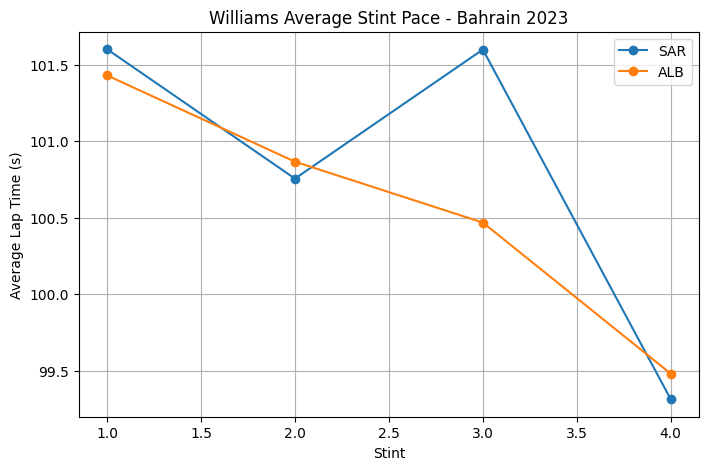

In [18]:
#Average stint pace comparison for Williams drivers
drivers = laps['Driver'].unique()

plt.figure(figsize=(8, 5))

for drv in drivers:
    drv_laps = laps.pick_drivers(drv)
    drv_stints = drv_laps['Stint'].unique()
    avg_stint_times = []

    for stint in drv_stints:
        stint_laps = drv_laps[drv_laps['Stint'] == stint]
        avg_time = stint_laps['LapTime'].mean()
        avg_stint_times.append(avg_time.total_seconds())

    plt.plot(drv_stints, avg_stint_times, marker='o', label=drv)

plt.xlabel("Stint")
plt.ylabel("Average Lap Time (s)")
plt.title("Williams Average Stint Pace - Bahrain 2023")
plt.legend()
plt.grid(True)
plt.show() 

### Interpretation – Williams Average Stint Pace (Bahrain 2023)

- **Stint 1**: Both drivers start around ~101.4–101.5s, with Sargeant slightly slower than Albon.  
- **Stint 2**: Both improve pace, dipping closer to 101s. Albon maintains a marginal edge.  
- **Stint 3**: Sargeant’s pace worsens, while Albon stays consistent. This suggests tyre degradation or setup differences impacted SAR more heavily.  
- **Stint 4**: Both drivers find their fastest stint pace (~99.3–99.5s). Albon again edges Sargeant, showing stronger tyre management in the final phase.  

**Key takeaway**: Albon shows greater consistency and adaptability across stints, while Sargeant fluctuates more in performance. Williams’ overall trend suggests late-race pace improvement (possibly due to lighter fuel load and better tyre compound).


## Qualifying Analysis 

Williams Qualifying Results (Bahrain 2023):


,DriverNumber,Abbreviation,Position,Q1,Q2,Q3
23,23,ALB,15.0,0 days 00:01:31.461000,NaT,NaT
2,2,SAR,16.0,0 days 00:01:31.652000,NaT,NaT



Williams Fastest Qualifying Laps:
ALB: 0 days 00:01:31.461000
SAR: 0 days 00:01:31.652000


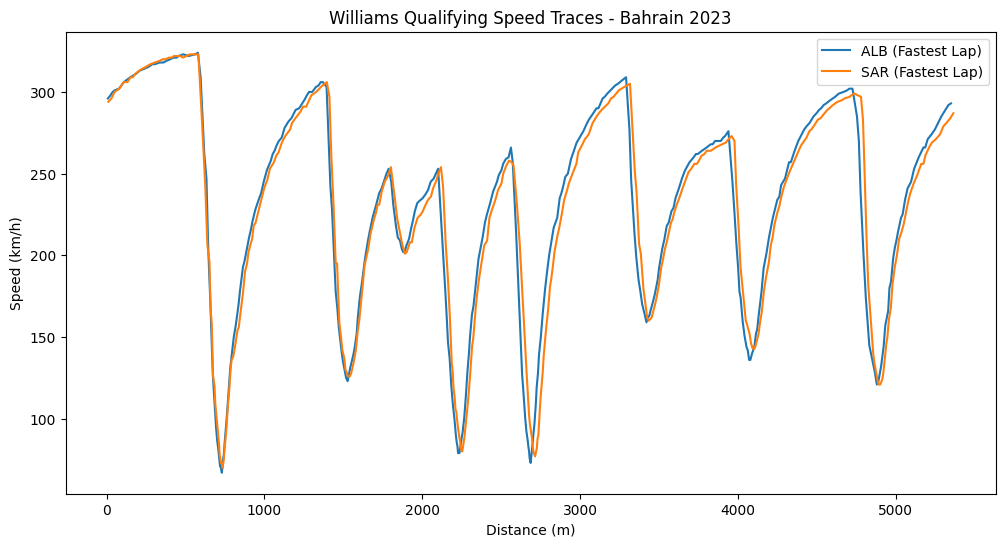

In [23]:
print("Williams Qualifying Results (Bahrain 2023):")
display(williams_q[['DriverNumber', 'Abbreviation', 'Position', 'Q1', 'Q2', 'Q3']])

#Extract fastest lap per driver
williams_qualy = qualifying.laps.pick_teams('Williams')
fastest_laps = {
    drv: williams_qualy.pick_drivers(drv).pick_fastest()
    for drv in williams_qualy['Driver'].unique()
}

print("\nWilliams Fastest Qualifying Laps:")
for drv, lap in fastest_laps.items():
    print(f"{drv}: {lap['LapTime']}")

#Speed trace comparison
fig, ax = plt.subplots(figsize=(12, 6))

for drv, lap in fastest_laps.items():
    tel = lap.get_car_data().add_distance()
    ax.plot(tel['Distance'], tel['Speed'], label=f"{drv} (Fastest Lap)")

ax.set_title("Williams Qualifying Speed Traces - Bahrain 2023")
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Speed (km/h)")
ax.legend()
plt.show()